# BASIC BIDIRECTIONAL RECURRENT NEURAL NETWORK

In this project I am going to design and develop a basic bidirectional RNN with Pytorch and CUDA. The goal is to create an English to French translator.

To carry out this project I implemented the knowledge I gained in the Udacity Natural Language Processing Nanodegree. 

In [1]:
import os
import random
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

C:\Users\jandr\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jandr\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\jandr\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 1. DATA

This type of project is computationally expensive, for this reason I will use a Dataset created by Udacity that uses a short vocabulary. This way I will test the architecture with a much lower computational and time cost.

### 1.1 Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [2]:
def load_data(path):
    input_file = os.path.join(path)
    with open(input_file, "r", encoding='utf-8') as f:
        data = f.read()

    return data.split('\n')

In [3]:
# Load English data
english_sentences = load_data('data/small_vocab_en')
# Load French data
french_sentences = load_data('data/small_vocab_fr')

print('DATA SET LOADED')

DATA SET LOADED


Show some examples:

In [4]:
print('Phrase in English: ', english_sentences[20])
print('Phrase in French: ', french_sentences[20])

Phrase in English:  china is usually pleasant during november , and it is never quiet in october .
Phrase in French:  chine est généralement agréable en novembre , et il est jamais tranquille en octobre .


### 1.2 Create and apply a word counter
The following function creates a dictionary with the word count, and return the number of words that have the longest phrase.

In [5]:
def world_count(texts):
    w_count = {}
    max_w = 0
    
    for i in texts:
        ws = i.split()
        
        for w in  ws:
            if w not in w_count:
                w_count[w] = 1
            else:
                w_count[w] += 1
                
        if len(ws)>max_w:
            max_w = len(ws)
            
    return w_count, max_w

In [6]:
en_w_count, en_max_w = world_count(english_sentences)
print('Max number of words in a english phrase: ', en_max_w)
print('English vocablary size: ', len(en_w_count))

fr_w_count, fr_max_w = world_count(french_sentences)
print('Max number of words in a french phrase: ', fr_max_w)
print('French vocablary size: ', len(fr_w_count))

Max number of words in a english phrase:  17
English vocablary size:  227
Max number of words in a french phrase:  23
French vocablary size:  355


Looking at the word counter we can see that the dataset we are using was carefully created, it does not have a large number of words and all of them are repeated an acceptable number of times.

In [7]:
print('======================  English word counter  ====================','\n','\n',en_w_count)

======================  English word counter  ==================== 
 
 {'new': 12197, 'jersey': 11225, 'is': 205858, 'sometimes': 37746, 'quiet': 8693, 'during': 74933, 'autumn': 9004, ',': 140897, 'and': 59850, 'it': 75137, 'snowy': 8898, 'in': 75525, 'april': 8954, '.': 129039, 'the': 67628, 'united': 11270, 'states': 11270, 'usually': 37507, 'chilly': 8770, 'july': 8956, 'freezing': 8928, 'november': 8951, 'california': 11250, 'march': 9023, 'hot': 8639, 'june': 9133, 'mild': 8743, 'cold': 8878, 'september': 8958, 'your': 9734, 'least': 27564, 'liked': 13546, 'fruit': 27105, 'grape': 4703, 'but': 63987, 'my': 9700, 'apple': 4652, 'his': 9700, 'favorite': 27371, 'orange': 4651, 'paris': 11334, 'relaxing': 8696, 'december': 8945, 'busy': 8791, 'spring': 9102, 'never': 37500, 'our': 8932, 'lemon': 4652, 'january': 9090, 'warm': 8890, 'lime': 4680, 'her': 9700, 'banana': 4652, 'he': 10786, 'saw': 648, 'a': 1944, 'old': 972, 'yellow': 972, 'truck': 1944, 'india': 11277, 'rainy': 8761, 't

In [8]:
print('======================  French word counter  ====================','\n','\n',fr_w_count)

======================  French word counter  ==================== 
 
 {'new': 11047, 'jersey': 11052, 'est': 196809, 'parfois': 37746, 'calme': 7256, 'pendant': 10741, "l'": 32917, 'automne': 14727, ',': 123135, 'et': 59851, 'il': 84079, 'neigeux': 1867, 'en': 105768, 'avril': 8954, '.': 135619, 'les': 65255, 'états-unis': 11210, 'généralement': 31292, 'froid': 16794, 'juillet': 8956, 'gèle': 3622, 'habituellement': 6215, 'novembre': 8951, 'california': 3061, 'mars': 9023, 'chaud': 16405, 'juin': 9133, 'légère': 63, 'fait': 2916, 'septembre': 8958, 'votre': 9368, 'moins': 27557, 'aimé': 24842, 'fruit': 23626, 'le': 35306, 'raisin': 4852, 'mais': 63987, 'mon': 9403, 'la': 49861, 'pomme': 4848, 'son': 16496, 'préféré': 22886, "l'orange": 4848, 'paris': 11334, 'relaxant': 8458, 'décembre': 8945, 'occupé': 7782, 'au': 25738, 'printemps': 9100, 'jamais': 37215, 'chaude': 1124, 'notre': 8319, 'citron': 4848, 'janvier': 9090, 'chaux': 4848, 'des': 2435, 'fruits': 3566, 'banane': 4848, 'aimé.'

### 1.3 Create and apply a word counter

Using the word counter I create a function that returns two Dictionary objects.  These dictionaries contain all the words that exceed a minimum number of repetitions in the dataset, and their assigned ID. One of the dictionaries has as key the word and as value the ID, and the other dictionary inverts the key and the value of the first one.

In [9]:
def create_dic(t_count, min_t=1, start=False, end=False, nan=False):
    id2t = {}
    t2id = {}
    id = 0
    
    if nan == True:                 # There is no word
        id2t[str(id)] = '<nan>'
        t2id['<nan>'] = id
        id += 1
    
    if start == True:               # start value of the phrase
        id2t[str(id)] = '<start>'
        t2id['<start>'] = id
        id += 1
        
    if end == True:                 # end value of the phrase
        id2t[str(id)] = '<end>'
        t2id['<end>'] = id
        id += 1
        
    for i in t_count:               
        if t_count[i] >= min_t:    # The word is repeated more than the minimum chosen
            
            t2id[i] = id
            id2t[str(id)] = i
            
            id += 1
            
    # add to the dictionary a token and an Id to the tokens that are not in the dictionary
    t2id['<str>'] = id            
    id2t[str(id)] = '<str>'

    return id2t, t2id

In [10]:
en_id2t, en_t2id = create_dic(en_w_count, min_t=1, start=False, end=False, nan=True)
fr_id2t, fr_t2id = create_dic(fr_w_count, min_t=1, start=False, end=False, nan=True)

**English dictionary whose key is the word and the value is the ID**

In [11]:
print(en_t2id)

{'<nan>': 0, 'new': 1, 'jersey': 2, 'is': 3, 'sometimes': 4, 'quiet': 5, 'during': 6, 'autumn': 7, ',': 8, 'and': 9, 'it': 10, 'snowy': 11, 'in': 12, 'april': 13, '.': 14, 'the': 15, 'united': 16, 'states': 17, 'usually': 18, 'chilly': 19, 'july': 20, 'freezing': 21, 'november': 22, 'california': 23, 'march': 24, 'hot': 25, 'june': 26, 'mild': 27, 'cold': 28, 'september': 29, 'your': 30, 'least': 31, 'liked': 32, 'fruit': 33, 'grape': 34, 'but': 35, 'my': 36, 'apple': 37, 'his': 38, 'favorite': 39, 'orange': 40, 'paris': 41, 'relaxing': 42, 'december': 43, 'busy': 44, 'spring': 45, 'never': 46, 'our': 47, 'lemon': 48, 'january': 49, 'warm': 50, 'lime': 51, 'her': 52, 'banana': 53, 'he': 54, 'saw': 55, 'a': 56, 'old': 57, 'yellow': 58, 'truck': 59, 'india': 60, 'rainy': 61, 'that': 62, 'cat': 63, 'was': 64, 'most': 65, 'loved': 66, 'animal': 67, 'dislikes': 68, 'grapefruit': 69, 'limes': 70, 'lemons': 71, 'february': 72, 'china': 73, 'pleasant': 74, 'october': 75, 'wonderful': 76, 'nice

**English dictionary whose key is the ID and the value is the word**

In [12]:
print(en_id2t)

{'0': '<nan>', '1': 'new', '2': 'jersey', '3': 'is', '4': 'sometimes', '5': 'quiet', '6': 'during', '7': 'autumn', '8': ',', '9': 'and', '10': 'it', '11': 'snowy', '12': 'in', '13': 'april', '14': '.', '15': 'the', '16': 'united', '17': 'states', '18': 'usually', '19': 'chilly', '20': 'july', '21': 'freezing', '22': 'november', '23': 'california', '24': 'march', '25': 'hot', '26': 'june', '27': 'mild', '28': 'cold', '29': 'september', '30': 'your', '31': 'least', '32': 'liked', '33': 'fruit', '34': 'grape', '35': 'but', '36': 'my', '37': 'apple', '38': 'his', '39': 'favorite', '40': 'orange', '41': 'paris', '42': 'relaxing', '43': 'december', '44': 'busy', '45': 'spring', '46': 'never', '47': 'our', '48': 'lemon', '49': 'january', '50': 'warm', '51': 'lime', '52': 'her', '53': 'banana', '54': 'he', '55': 'saw', '56': 'a', '57': 'old', '58': 'yellow', '59': 'truck', '60': 'india', '61': 'rainy', '62': 'that', '63': 'cat', '64': 'was', '65': 'most', '66': 'loved', '67': 'animal', '68': '

### 1.4 Data preprocessing

The first step in preprocessing the data is to transform the sentences into lists, where the list values are the words, creating a list of lists. The second step is to change the words with the respective IDs.

The following function does these two steps:


In [13]:
def tokenize(list, dict):
    list = [dict[i] for i in list]
    return list

For this basic model the entries are arrays with the same size (the maximum number of words that the longest phrase in our data set has). For this reason we need to add values (in our case zeros) in the list until we have the desired length.

In [14]:
def tokenize_list(list, dict):
    list = tokenize(list, dict)
    size = len(dict)
    out = []
    
    for i in list:
        arr = [0.]*size
        arr[i] = 1.
        out.append(arr)
    
    return out

### 1.5 Create Trining, Validation and Test Datasets

The next step separates the phrases we have in the three datasets in a random way according to the proportion we choose

In [15]:
tr_db = []
te_db = []
va_db = []

tr_va_p = 0.7 
tr_p = 0.7

if fr_max_w > en_max_w:
    ph_lon = fr_max_w
else:
    ph_lon = en_max_w
    
for (en,fr) in zip(english_sentences, french_sentences):
    
    en = tokenize(en.split(), en_t2id)
    en = en + [0]*(ph_lon-len(en))
    fr = tokenize(fr.split(), fr_t2id)
    fr = fr + [0]*(ph_lon-len(fr))
    
    if random.random() < tr_va_p:
        if random.random() < tr_p:
            tr_db.append((torch.LongTensor(en), torch.LongTensor(fr)))
        else:
            va_db.append((torch.LongTensor(en), torch.LongTensor(fr)))
    else:
        te_db.append((torch.LongTensor(en), torch.LongTensor(fr)))

## 2. THE RNN

This model is created using a bidirectional LSTM, the layers we use in the model are:
* Embeding Layers (nn.Embedding()): A simple lookup table that stores embeddings of a fixed dictionary and size.
* Long Sort Term Memory Layer (LSTM())
* Full Conect Layers (Dense())
* Drop Out Layer

#### 2.1 The Architecture
For this model the input is an integer value representing the word ID and 0 if it is not a word. The output is an array with a length equal to the French dictionary, the position with the highest value in the array is the word in the French dictionary. The next image show hot it work
<img src='images/lstm1.png' width=50% height=50%/>

In [16]:
import torch
from torch import nn
import torch.nn.functional as F

class RNN(nn.Module):

    def __init__(self, en_dic = len(en_t2id), fr_dic=len(fr_t2id), device='cuda'):
        super(RNN, self).__init__()
        
        self.device = device
        
        # Embeding Layer
        # https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.emb = nn.Embedding(en_dic+1, 250)            
        
        # Bidirectional LSTM Layer
        # https://pytorch.org/docs/1.9.1/generated/torch.nn.LSTM.html
        self.LSTM1 = nn.LSTM(250, 250, num_layers=1, batch_first=True, bidirectional=True, dropout=0.5)
        
        # Dense Layer
        self.Dense1 = nn.Linear(2*250, fr_dic*5)
        self.Dense2 = nn.Linear(fr_dic*5, fr_dic)
        
        # Batch Norm Layer
        self.batch_norm1 = nn.BatchNorm1d(23)
        self.batch_norm2 = nn.BatchNorm1d(23)
        
        # Dropout Layer
        self.drop = nn.Dropout(p=0.5)
        
    def forward(self, x):
        
        self.batch_size = x.shape[0]
        self.hidden = ( torch.zeros(2, self.batch_size, 250).to(self.device), 
                       torch.zeros(2, self.batch_size, 250).to(self.device) )
        
        x = self.emb(x)
        out, self.hidden = self.LSTM1(x, self.hidden)
        out = F.relu(out) 
#         out = self.batch_norm1(out)
        out = self.Dense1(out)
        out = F.relu(out)
#         out = self.batch_norm2(out)
        out = self.drop(out)
        out = self.Dense2(out)
        
        return(out)
    
print(RNN())

RNN(
  (emb): Embedding(230, 250)
  (LSTM1): LSTM(250, 250, batch_first=True, dropout=0.5, bidirectional=True)
  (Dense1): Linear(in_features=500, out_features=1785, bias=True)
  (Dense2): Linear(in_features=1785, out_features=357, bias=True)
  (batch_norm1): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)


C:\Users\jandr\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## 3. Training and Test

#### 3.1 Hyperparameters

In [17]:
batch_size = 25
epochs = 25
device = 'cuda'
#device = 'cpu'
display_step = 100
rnn = RNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, betas=(0.9, 0.999))

tr_ds = DataLoader(tr_db, batch_size=batch_size, shuffle=True)
te_ds = DataLoader(te_db, batch_size=20, shuffle=False)
va_ds = DataLoader(va_db, batch_size=20, shuffle=False)

#### 3.2 Train the Model
In the following code fragment we train the model, and after each epoch the loss value is calculated with the validation data set. The model with the best result on the validation data set is saved.

In [18]:
h_loss = []
h_loss_it = []
val_loss = []
val_loss_it = []
avg_loss = 0
count = 0
T_it = 0
best_model = False

it = 0

for epoch in range(epochs):
    
    for eng, fre in tqdm(tr_ds):
        it += 1
        T_it += 1
        
        eng = eng.to(device)
        fre = fre.to(device)
        
        # clear all the gradients
        optimizer.zero_grad()
        pred = rnn(eng)
        
        loss = criterion(pred.view(-1, len(fr_t2id)), fre.view(-1)) 
        # Backward pass.
        loss.backward()
        # Update the parameters in the optimizer.
        optimizer.step()
        
        count += pred.shape[0]
        avg_loss += loss.item() * pred.shape[0]
        
        if it%display_step == 0:
            h_loss.append(avg_loss/count)
            h_loss_it.append(T_it)
            b = 'Epoch: '+str(epoch+1)+'; training loss value: '+str(avg_loss/count)+'; Validation loss best model: '+str(best_model)
            print(b, end="\r")
            it = 0
            count = 0
            avg_loss = 0
            
    loss_va = 0
    count_va = 0
    for eng, fre in va_ds:
        
        eng = eng.to(device)
        fre = fre.to(device)
        pred = rnn(eng)
        loss = criterion(pred.view(-1, len(fr_t2id)), fre.view(-1)).item() 
        count_va += pred.shape[0]
        loss_va += loss * pred.shape[0]
        
    
    loss_va = loss_va/count_va
    val_loss.append(loss_va)
    val_loss_it.append(T_it)
    
    if best_model==False or loss_va < best_model :
        print('Best Model => loss validation: ', loss_va)
        best_model = loss_va
        model_dir = 'models/'
        model_name = 'En2Fr_tr_best_model_1.pkl'
        torch.save(rnn.state_dict(), model_dir+model_name)

Epoch: 1; training loss value: 0.21237486988306045; Validation loss best model: False
Best Model => loss validation:  0.21003732483313248


Epoch: 2; training loss value: 0.14779297553002835; Validation loss best model: 0.21003732483313248
Best Model => loss validation:  0.16452382799899082


Epoch: 3; training loss value: 0.11665285008028149; Validation loss best model: 0.16452382799899082
Best Model => loss validation:  0.12676450346873505


Epoch: 4; training loss value: 0.09843497492372989; Validation loss best model: 0.12676450346873505
Best Model => loss validation:  0.12031215741710279


Epoch: 5; training loss value: 0.09286088523454965; Validation loss best model: 0.12031215741710279
Best Model => loss validation:  0.10974649041865349


Epoch: 6; training loss value: 0.07785409480333329; Validation loss best model: 0.10974649041865349
Best Model => loss validation:  0.1033988685669168


Epoch: 7; training loss value: 0.07627421802841126; Validation loss best model: 0.1033988685669168
Best Model => loss validation:  0.09643795218139099


Epoch: 8; training loss value: 0.0740972476825118; Validation loss best model: 0.0964379521813909999


Epoch: 9; training loss value: 0.07607283541932702; Validation loss best model: 0.096437952181390999
Best Model => loss validation:  0.09478478351614678


Epoch: 10; training loss value: 0.06126931469887495; Validation loss best model: 0.094784783516146788
Best Model => loss validation:  0.09312386090135134


Epoch: 11; training loss value: 0.05779385215602815; Validation loss best model: 0.093123860901351344


Epoch: 12; training loss value: 0.05426952555309981; Validation loss best model: 0.093123860901351344


Epoch: 13; training loss value: 0.049223089085426185; Validation loss best model: 0.09312386090135134
Best Model => loss validation:  0.09190128907752491


Epoch: 14; training loss value: 0.051730382626410575; Validation loss best model: 0.09190128907752491


Epoch: 15; training loss value: 0.05414232852868736; Validation loss best model: 0.091901289077524911


Epoch: 16; training loss value: 0.04669352049240842; Validation loss best model: 0.091901289077524911


Epoch: 17; training loss value: 0.04348451728001237; Validation loss best model: 0.091901289077524911


Epoch: 18; training loss value: 0.039777481248602274; Validation loss best model: 0.09190128907752491


Epoch: 19; training loss value: 0.041475646081380546; Validation loss best model: 0.09190128907752491


Epoch: 20; training loss value: 0.03785127162700519; Validation loss best model: 0.091901289077524911


Epoch: 21; training loss value: 0.043598038689233364; Validation loss best model: 0.09190128907752491


Epoch: 22; training loss value: 0.039084252649918196; Validation loss best model: 0.09190128907752491


Epoch: 23; training loss value: 0.04275313026504591; Validation loss best model: 0.091901289077524911


Epoch: 24; training loss value: 0.03569226786959916; Validation loss best model: 0.091901289077524911


Epoch: 25; training loss value: 0.030855008186772465; Validation loss best model: 0.09190128907752491


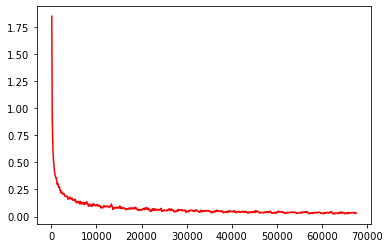

In [19]:
plt.plot(h_loss_it, h_loss, 'r')

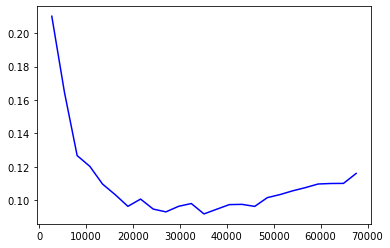

In [20]:
plt.plot(val_loss_it, val_loss, 'b')

### 3.1 Testing the model
After training the model it is necessary to test it with the test data set. With this step we can determine if our model has an over-fit, and know what the final accuracy is.

In [21]:
rnn = RNN(device='cpu')
path = 'models/En2Fr_tr_best_model_1.pt'
rnn.load_state_dict(torch.load(path))
rnn.eval()

RNN(
  (emb): Embedding(230, 250)
  (LSTM1): LSTM(250, 250, batch_first=True, dropout=0.5, bidirectional=True)
  (Dense1): Linear(in_features=500, out_features=1785, bias=True)
  (Dense2): Linear(in_features=1785, out_features=357, bias=True)
  (batch_norm1): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [38]:
loss_va = 0
count_va = 0
for eng, fre in te_ds:

    eng = eng.to('cpu')
    fre = fre.to('cpu')
    pred = rnn(eng)
    loss = criterion(pred.view(-1, len(fr_t2id)), fre.view(-1)).item() 
    count_va += pred.shape[0]
    loss_va += loss * pred.shape[0]


loss_va = loss_va/count_va

In [39]:
print('The loss value with the Test Dataset is: ', loss_va)

The loss value with the Test Dataset is:  0.0796529366653519


The model has good accuracy

### Show some examples

In [55]:
for expected, prediction in zip(fre,pred.max(2)[1]):
    exp = ''
    predic = ''
    for i in expected:
        if i!=0:
            exp += fr_id2t[str(i.item())] + ' '
    for i in prediction:
        if i!=0:
            predic += fr_id2t[str(i.item())] + ' '
    
    print( 'Expected: ',exp )
    print( 'Prediction: ', predic )
    print('======================================')
    
    


Expected:  il conduit une vieille voiture verte . 
Prediction:  il conduit une vieille automobile verte . 
Expected:  new jersey est parfois froid en avril , mais il est généralement doux à l' automne . 
Prediction:  new jersey est parfois frisquet en avril , mais il est généralement doux à l' automne . 
Expected:  la france est jamais occupée en mars , et il est parfois agréable en septembre . 
Prediction:  la france est jamais occupée en mars , et il est parfois agréable en septembre . 


In these 3 examples we can see that the model has a tight prediction. In 2 cases the model does not predict the expected word, but predicts a word with a very similar meaning.